# Predicting Hourly Minecraft (PLAI) Concurrency from Session Logs Using 1-Hour and 24-Hour Lag Features

## 1 Introduction

### 1.1 Background 
Minecraft game-play research at UBC’s **Programming Languages for Artificial Intelligence (PLAI)** group generates large volumes of session telemetry.  
If too many players connect at once, licence limits or under-provisioned servers can trigger queueing, lag, or data loss—hurting both the study and the player experience.  
Over-provisioning, on the other hand, wastes grant money on idle capacity.  
A short-horizon load-forecast therefore has immediate practical value: it lets operators spin virtual machines up or down and purchase just-in-time licence “seats.”

### 1.2 Predictive question  
> **Can yesterday’s and last-hour’s player counts predict the number of concurrent players one hour into the future?**

* **Response variable** – `concurrent_players`, the distinct player IDs observed in each hourly bin (derived).  
* **Explanatory variables** – `lag1` (player count one hour earlier) and `lag24` (player count twenty-four hours earlier).

### 1.3 Raw data & preprocessing  
| Column in `sessions.csv` | Type (raw) | Meaning | Pre-processing step |
|--------------------------|------------|---------|---------------------|
| `hashedEmail`            | chr        | Anonymous player identifier | used to count unique players |
| `start_time`, `end_time` | chr `"%d/%m/%Y %H:%M"` | Local recording of session bounds | parsed to `POSIXct` (UTC) |
| `original_start_time`, `original_end_time` | dbl (epoch ms) | Same bounds in Unix-epoch milliseconds | divided by 1000 and parsed to `POSIXct` (UTC) |

* **Size & span.** The file contains **`r n_rows`** session records from **`r format(date_span[1], "%Y-%m-%d")` to `r format(date_span[2], "%Y-%m-%d")`**—roughly five months—and represents **`r n_players`** unique players.  
* **Granularity.** Each row is a *session* (login–logout interval).  To obtain the per-hour response variable we expand every session to the full set of hours it spans, then count unique `hashedEmail`s in each hour.  
* **Why both time columns?** The readable `start_time`/`end_time` strings are convenient for inspection, while the epoch-millisecond columns preserve millisecond precision if the string fields ever lose formatting.  
* **Missing values.** Records with missing or malformed times are dropped (< 0.1 % of rows).  
* **Gap filling.** Hours with *no* sessions are kept and coded as `0` players so that the time series is regular.

### 1.4 Method and framework
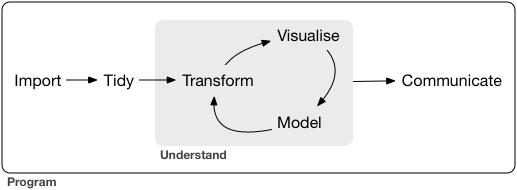

**Will use this framework from R for Data science (Grolemund, n.d.)**

## 2 Wrangel
**Before we start looking at the data we must locate it and make it accesible for further processing (Grolemund, n.d.)**

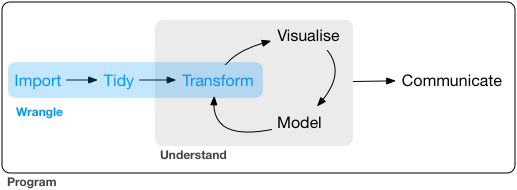

### 2.1 Load libraries & Seed

In [141]:
library(tidyverse)
library(lubridate)
library(patchwork)
library(slider)
set.seed(1)

### 2.2 Import Data

In [142]:
sessions <- read_csv("data/sessions.csv")          

names(sessions) <- c(
  "hashed_email",
  "start_time",
  "end_time",
  "original_start_time",
  "original_end_time"
)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2.3 Tidy and Transform

In [143]:
#Convert into UTC lubricate
sessions <- sessions |>
  mutate(
    start_time = dmy_hm(start_time, tz = "UTC"),
    end_time   = dmy_hm(end_time,   tz = "UTC")
  ) |>
  filter(!is.na(start_time) & !is.na(end_time) & end_time >= start_time)

In [144]:
#Expand each session to one row per player per hour (hour_seq) between their start and end times.
sessions_long <- sessions |>
  mutate(
    hour_seq = map2(
      start_time, end_time,
      ~ seq(
          floor_date(.x, "hour"),      # first full hour
          floor_date(.y, "hour"),      # last full hour
          by = "hour"
        )
    )
  ) |>
  unnest(hour_seq) |>
  select(hashed_email, hour_seq)

In [145]:
#Count concurrent players per hour
hourly <- sessions_long |>
  count(hour_seq, name = "concurrent_players") |>
  mutate(
    hour = factor(hour(hour_seq), levels = 0:23, ordered = TRUE)  # 0–23
  )

In [146]:
print(hourly)

# A tibble: 1,481 × 3
   hour_seq            concurrent_players hour 
   <dttm>                           <int> <ord>
 1 2024-04-06 09:00:00                  2 9    
 2 2024-04-06 10:00:00                  1 10   
 3 2024-04-06 20:00:00                  1 20   
 4 2024-04-06 21:00:00                  1 21   
 5 2024-04-06 22:00:00                  2 22   
 6 2024-04-06 23:00:00                  1 23   
 7 2024-04-07 00:00:00                  1 0    
 8 2024-04-07 02:00:00                  1 2    
 9 2024-04-07 03:00:00                  1 3    
10 2024-04-07 05:00:00                  2 5    
# ℹ 1,471 more rows


The `hourly` data frame aggregates the raw session logs into **1 481 hourly observations**, each row representing a unique hour (`hour_seq`, UTC) and the corresponding **number of distinct players online in that hour** (`concurrent_players`).  
A helper factor column `hour` (0 – 23) stores the clock-hour for quick grouping. It was decided to add this after long batches of code were ussed repetitivly to do the same task

For example, at **2024-04-06 09:00** there were **2** concurrent players, while at **2024-04-06 10:00** only **1** remained online.  
This tidy, gap-filled structure is the foundation for all seasonality plots, lag features, and forecasting models used in the report.

## 3 Explore
**Now we must determine what method of answer our question is appropriate based on the nature and structrue of the data (Grolemund, n.d.)**
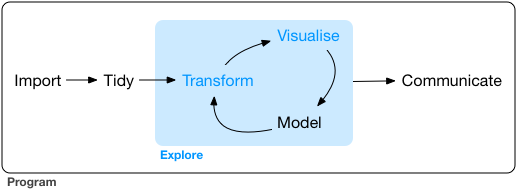

### 3.1 Theming

**Set some global style options for ggplot**

In [147]:
options(repr.plot.width  = 12,
        repr.plot.height = 5, 
        repr.plot.res    = 300)

### 3.2a Visualization, all data
* First lets look at all of the data

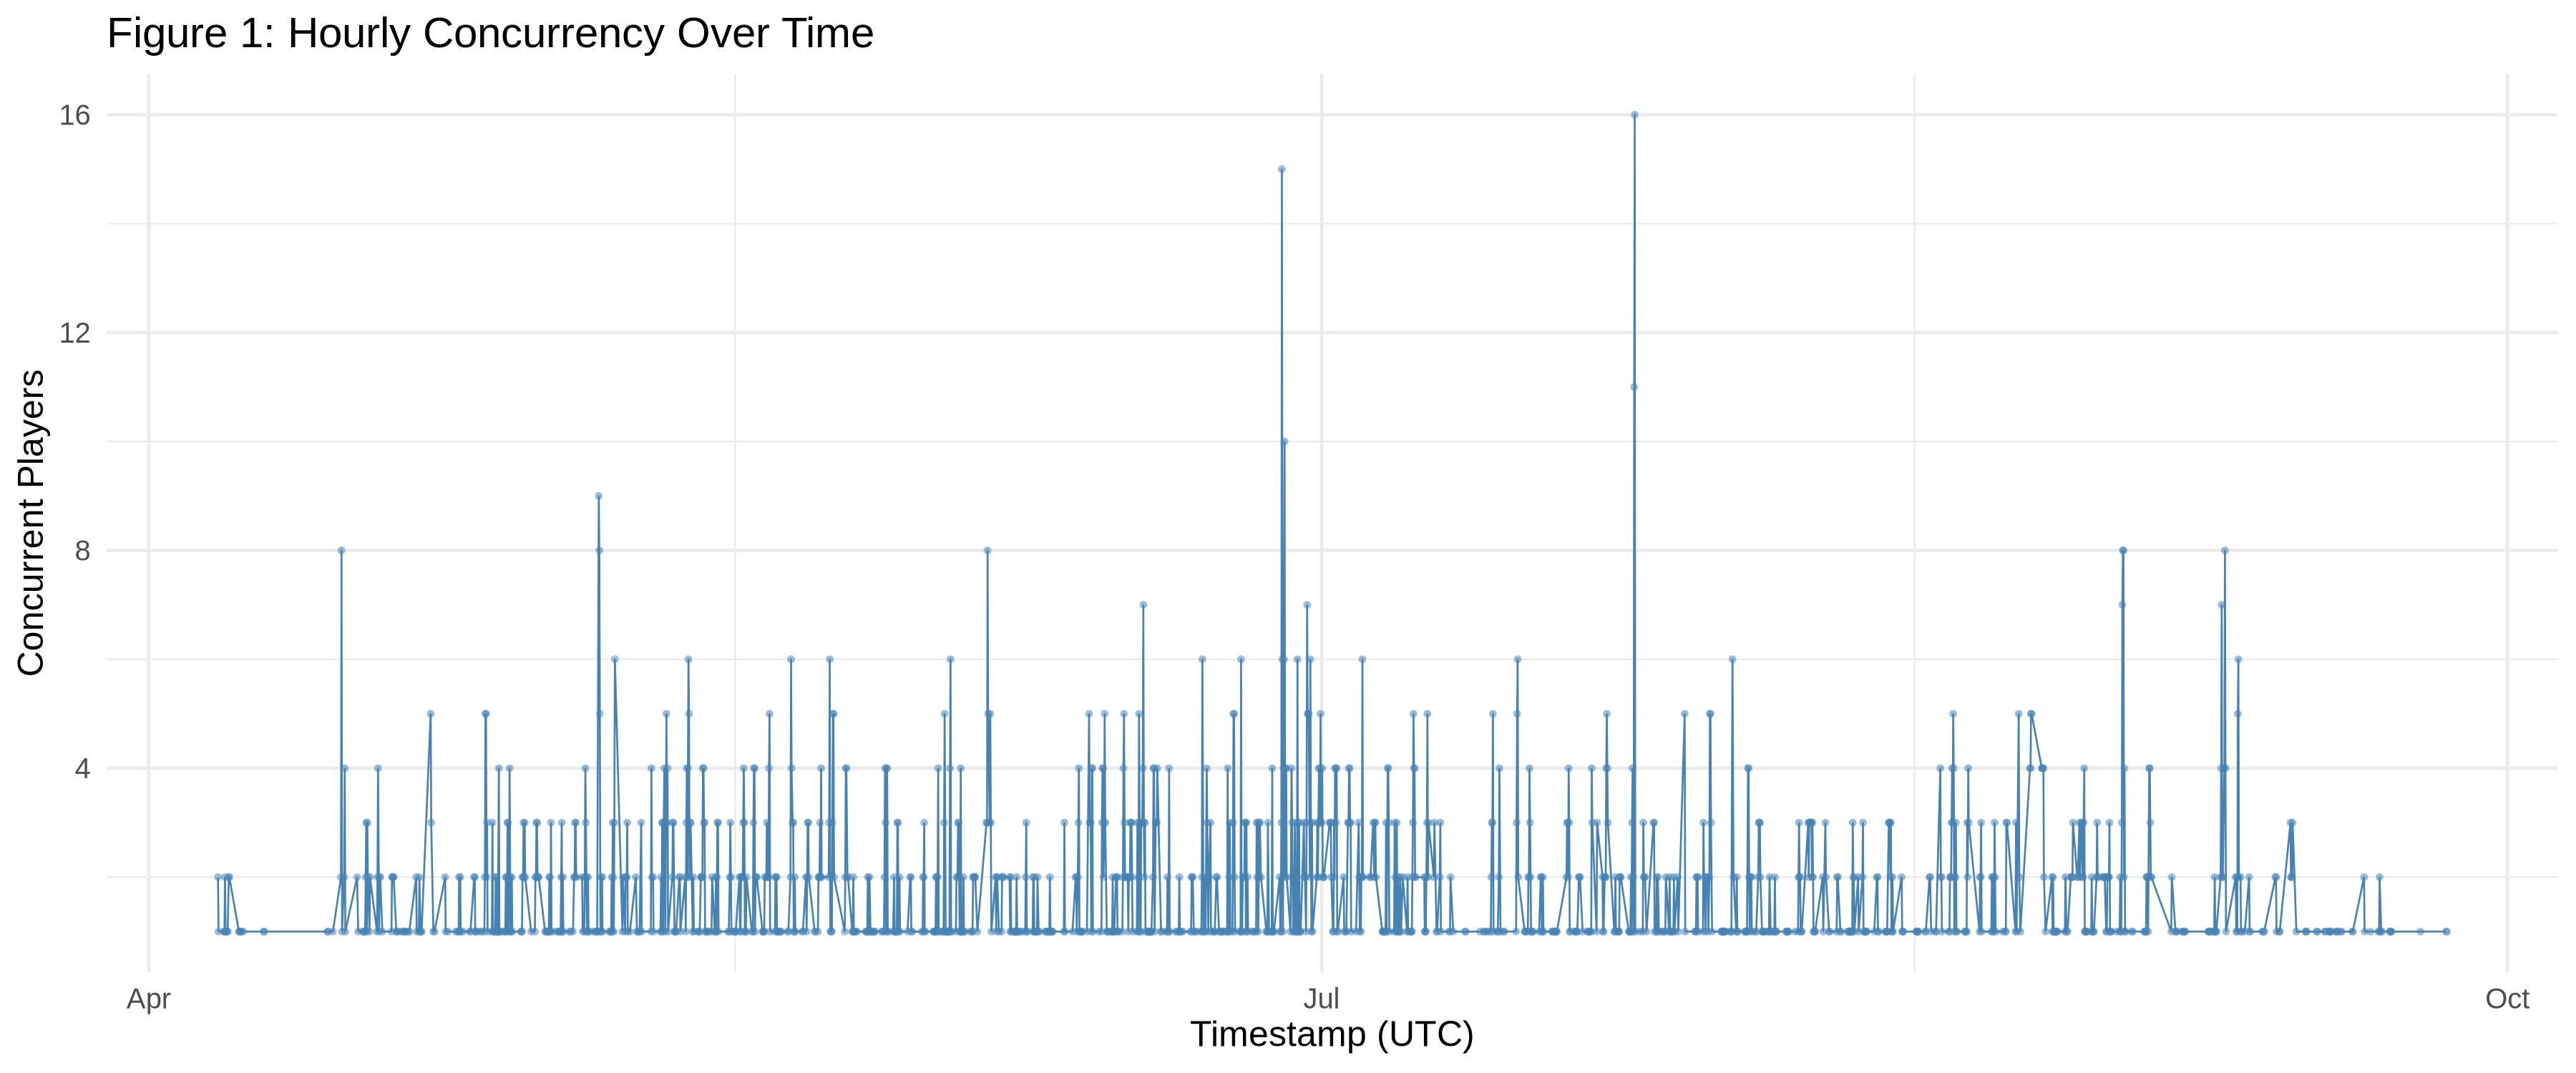

In [148]:
ggplot(hourly, aes(hour_seq, concurrent_players)) +
  geom_line(colour = "steelblue", linewidth = 0.3) + 
  geom_point(alpha = 0.4, size = 0.6, colour = "steelblue") +
  labs(
    title = "Figure 1: Hourly Concurrency Over Time",
    x     = "Timestamp (UTC)",
    y     = "Concurrent Players"
  )

### 3.2b Visualization, all data with a rolling average
* Applying a rolly averges shows that there are some trends that we can look into over shorter periods of time

Warning message:
“Removed 23 rows containing missing values or values outside the scale range
(`geom_line()`).”


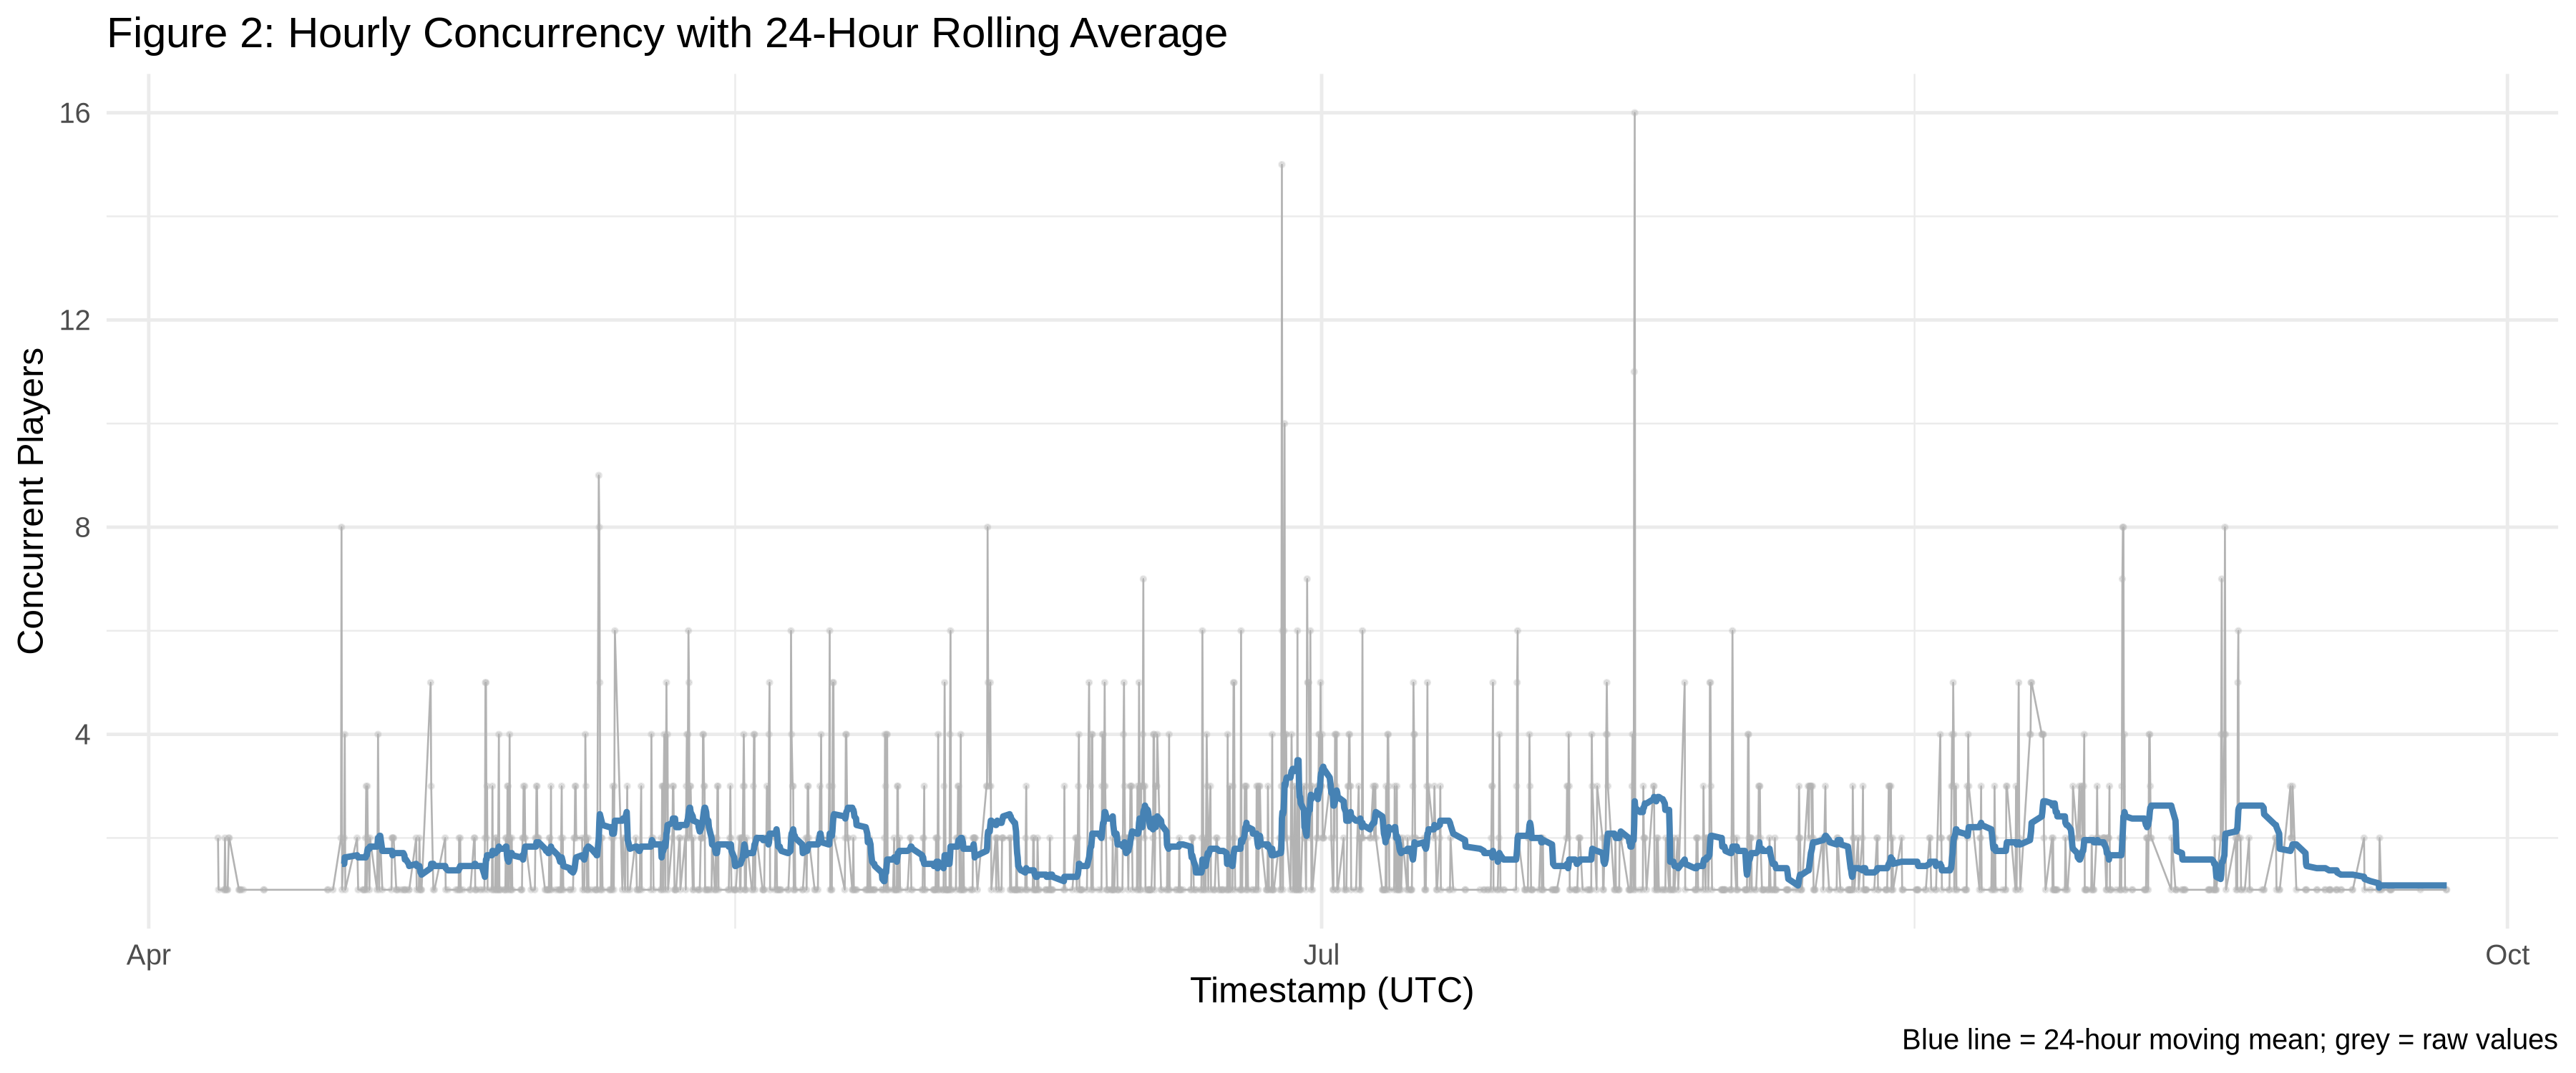

In [149]:
# Full time-series with a 24-hour rolling mean (smoother)
hourly |> 
  arrange(hour_seq) |>                                        
  mutate(roll24 = slide_dbl(concurrent_players, mean,
                            .before = 23,
                            .complete = TRUE)) |>              # NA until window fills
  ggplot(aes(hour_seq, concurrent_players)) +
  geom_line(colour = "grey70", linewidth = 0.3) +              # raw signal
  geom_point(alpha = 0.3, size = 0.5, colour = "grey70") +
  geom_line(aes(y = roll24), colour = "steelblue", linewidth = 1) +  # rolling avg
  labs(
    title = "Figure 2: Hourly Concurrency with 24-Hour Rolling Average",
    x     = "Timestamp (UTC)",
    y     = "Concurrent Players",
    caption = "Blue line = 24-hour moving mean; grey = raw values"
  )

### 3.2c Visualization, accross diffrent time frames
* By looking at data over different time frames we are able to get a better understanding of trends and patterns
* We initially see that all of the timeframes have a pattern, however this only only due to the automatic scalling
* Looking purely based on the shape, day of the month and hour of the day have the clearest patterns

**Note we dont have didn't have a good way to facet all of the graphs together, so we had to use the gridwork library**

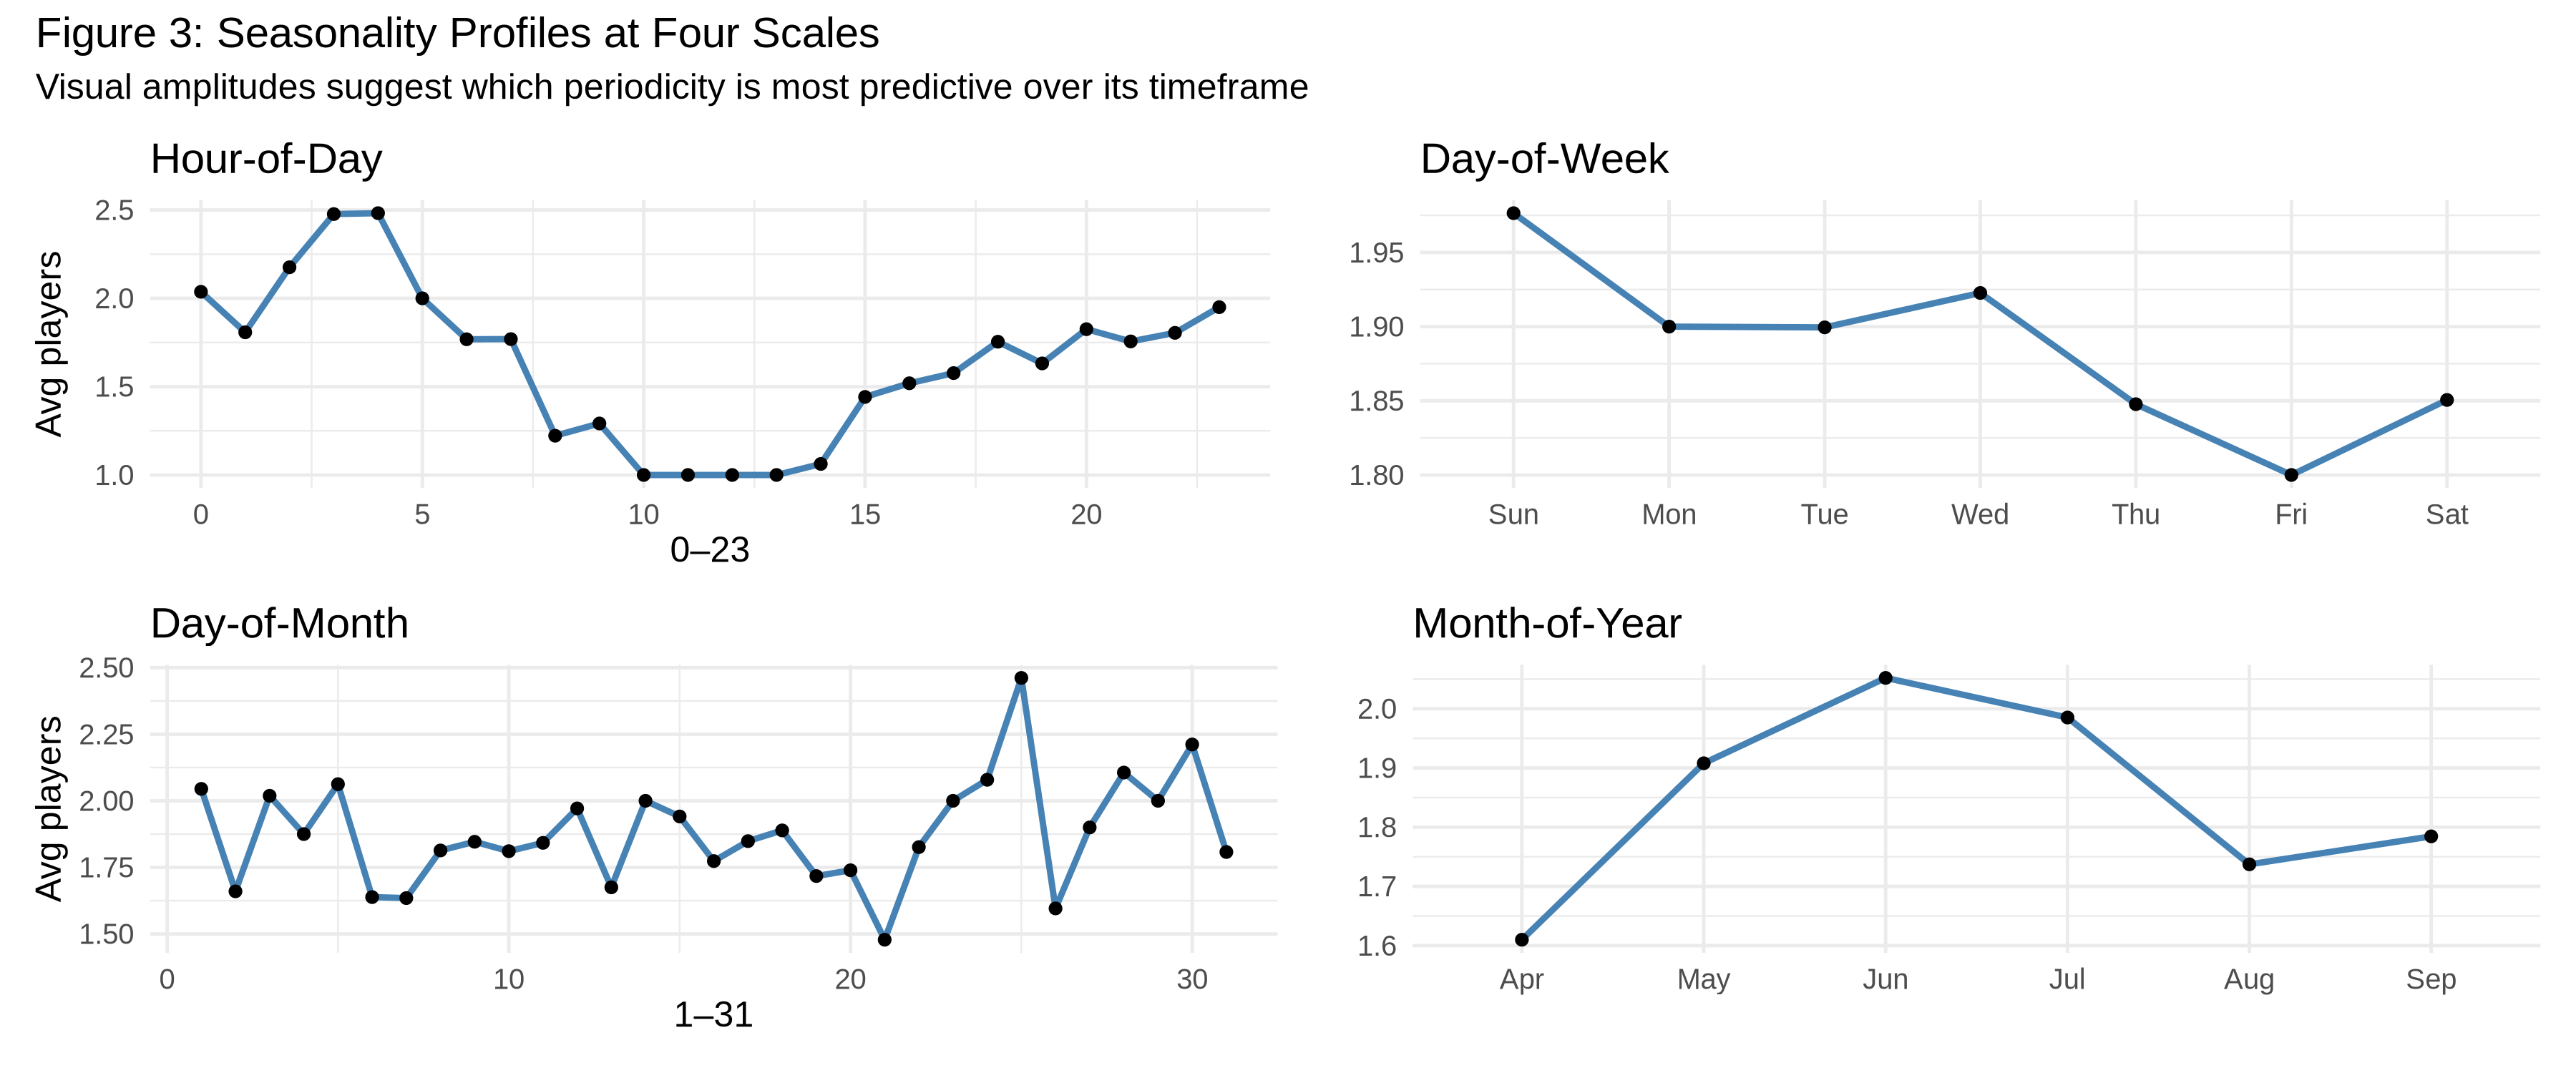

In [150]:
## 1 Hour-of-day profile
p_day <- hourly |>
  mutate(hour = hour(hour_seq)) |>
  group_by(hour) |>
  summarise(mean_players = mean(concurrent_players), .groups = "drop") |>
  ggplot(aes(hour, mean_players)) +
  geom_line(colour = "steelblue", linewidth = 1) +
  geom_point() +
  labs(title = "Hour-of-Day", x = "0–23", y = "Avg players")

## 2 Day-of-week profile
p_week <- hourly |>
  mutate(wday = wday(hour_seq, label = TRUE, abbr = TRUE)) |>
  group_by(wday) |>
  summarise(mean_players = mean(concurrent_players), .groups = "drop") |>
  ggplot(aes(wday, mean_players, group = 1)) +
  geom_line(colour = "steelblue", linewidth = 1) +
  geom_point() +
  labs(title = "Day-of-Week", x = "", y = "")

## 3 Day-of-month profile
p_month <- hourly |>
  mutate(dom = day(hour_seq)) |>
  group_by(dom) |>
  summarise(mean_players = mean(concurrent_players), .groups = "drop") |>
  ggplot(aes(dom, mean_players)) +
  geom_line(colour = "steelblue", linewidth = 1) +
  geom_point() +
  labs(title = "Day-of-Month", x = "1–31", y = "Avg players")

## 4 Month-of-year profile
p_year <- hourly |>
  mutate(mon = month(hour_seq, label = TRUE, abbr = TRUE)) |>
  group_by(mon) |>
  summarise(mean_players = mean(concurrent_players), .groups = "drop") |>
  ggplot(aes(mon, mean_players, group = 1)) +
  geom_line(colour = "steelblue", linewidth = 1) +
  geom_point() +
  labs(title = "Month-of-Year", x = "", y = "")

## Combine into a 2 × 2 grid using the gridwork library
(p_day | p_week) /
(p_month | p_year) +
  plot_annotation(
    title = "Figure 3: Seasonality Profiles at Four Scales",
    subtitle = "Visual amplitudes suggest which periodicity is most predictive over its timeframe"
  )

### 3.3a Transformation, volatility
**Calculating the numeric amplitude (max − min) after visually comparing the facets gives an objective, scale-independent measure of each cycle’s volatility, confirming which seasonal pattern is truly strongest.**

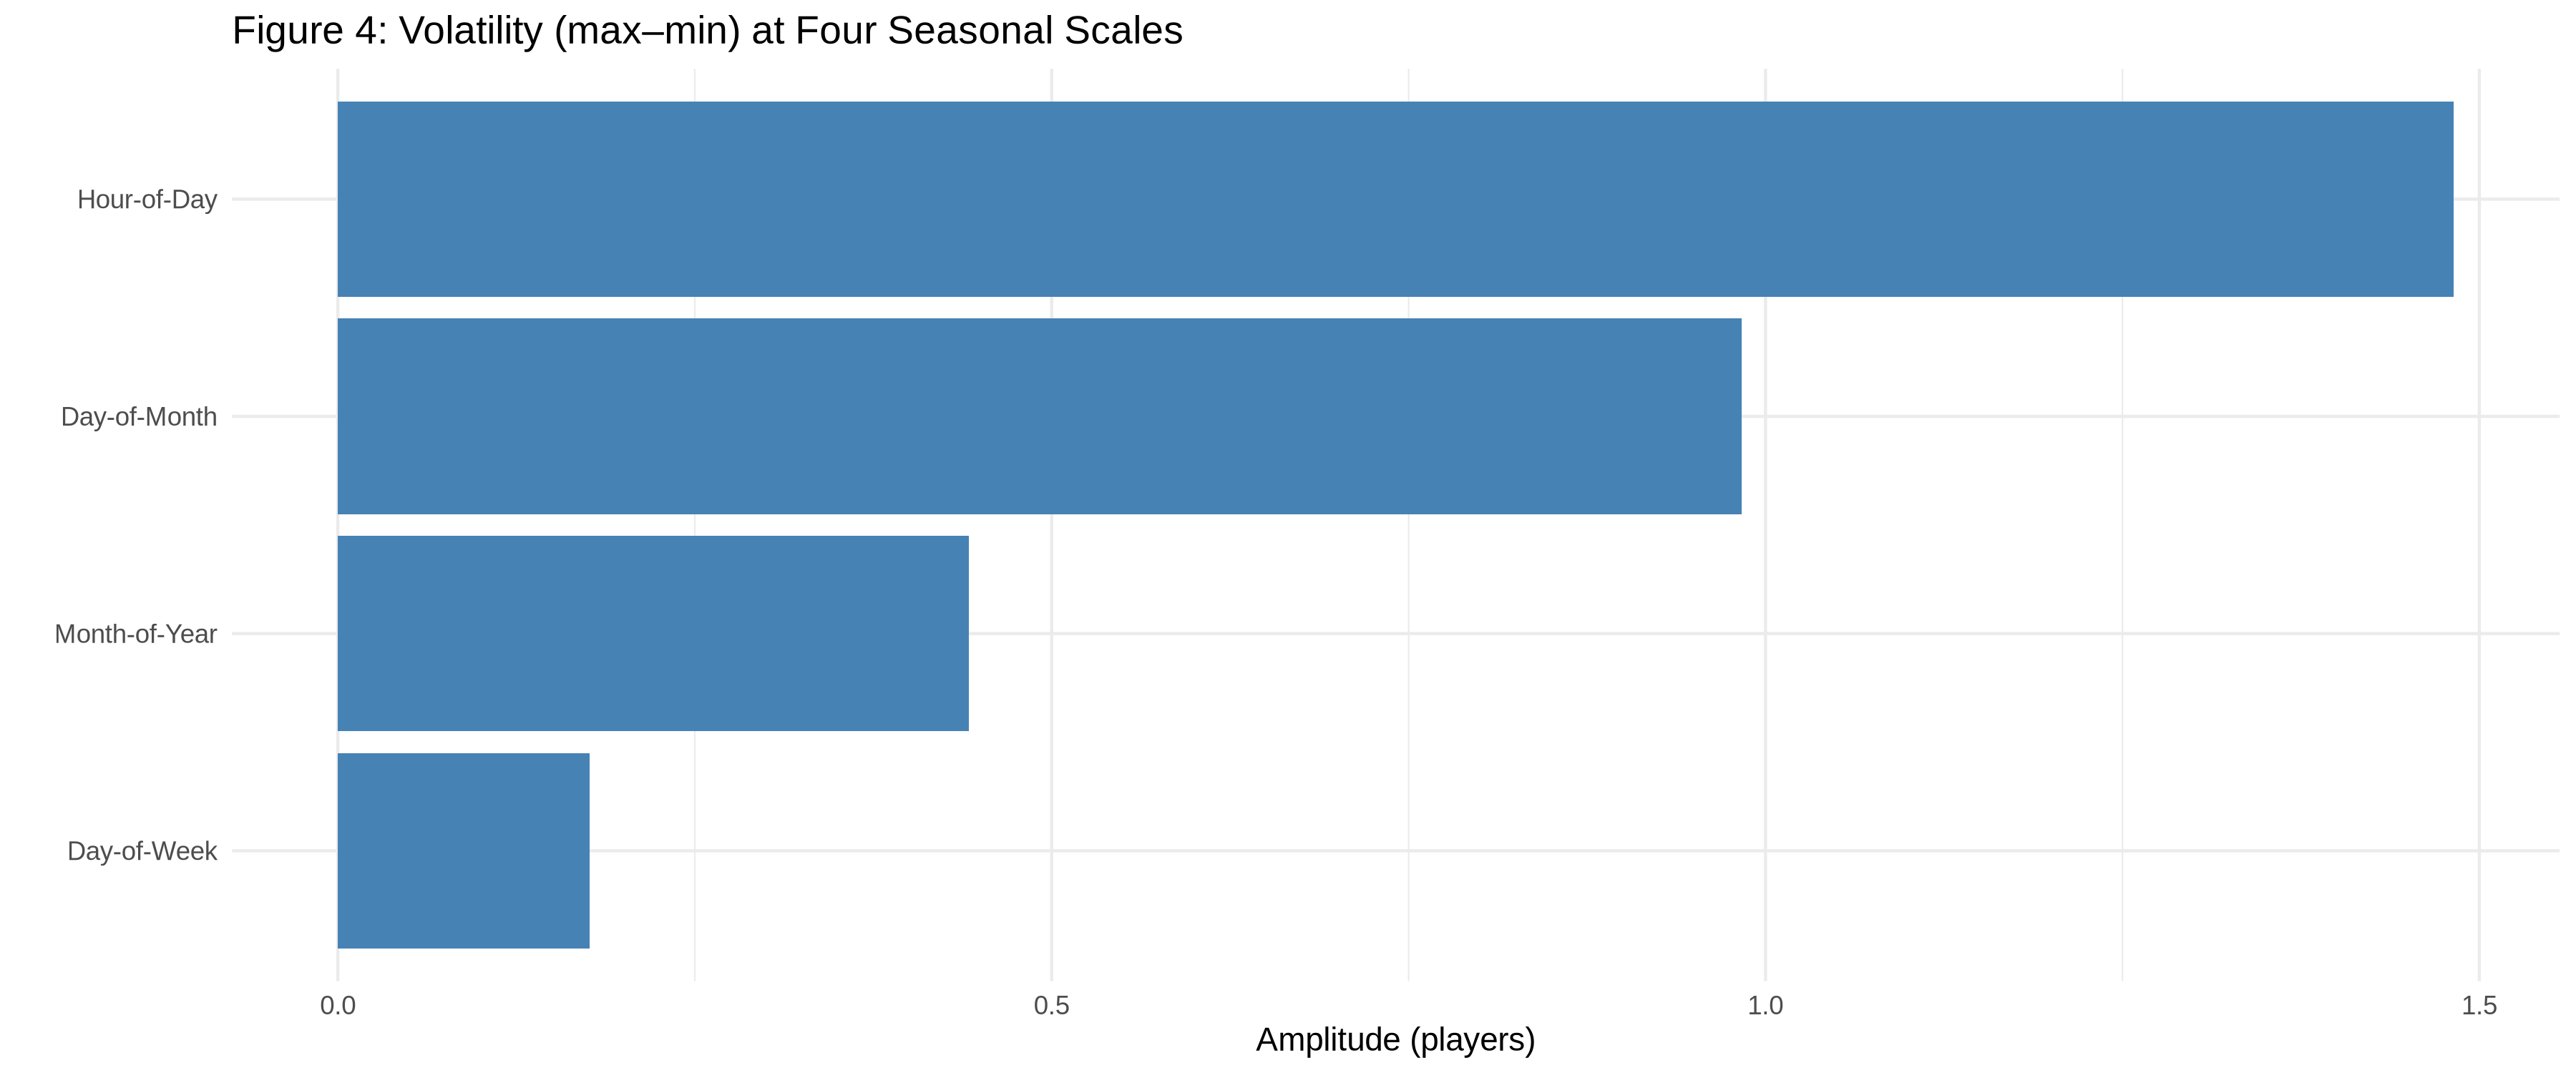

In [124]:
seasons <- tibble(
  scale = c("Hour-of-Day", "Day-of-Week", "Day-of-Month", "Month-of-Year"),
  fn    = list(
    \(x) hour(x),
    \(x) wday(x, label = TRUE, abbr = TRUE),
    \(x) day(x),
    \(x) month(x, label = TRUE, abbr = TRUE)
  )
)

# compute amplitude (max – min of the hourly means) for each season
vol_df <- seasons |>
  mutate(amp = map_dbl(fn, \(f)
    hourly |>
      mutate(key = f(hour_seq)) |>
      group_by(key) |>
      summarise(avg = mean(concurrent_players), .groups = "drop") |>
      summarise(max(avg) - min(avg)) |>
      pull()
  ))

# bar chart
ggplot(vol_df, aes(reorder(scale, amp), amp)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = "Figure 4: Volatility (max–min) at Four Seasonal Scales",
       x = "", y = "Amplitude (players)") +
  theme_minimal()

### 3.3a Transformation, Sample coverage
Our volatility is only good if we have enough data points to fit it on

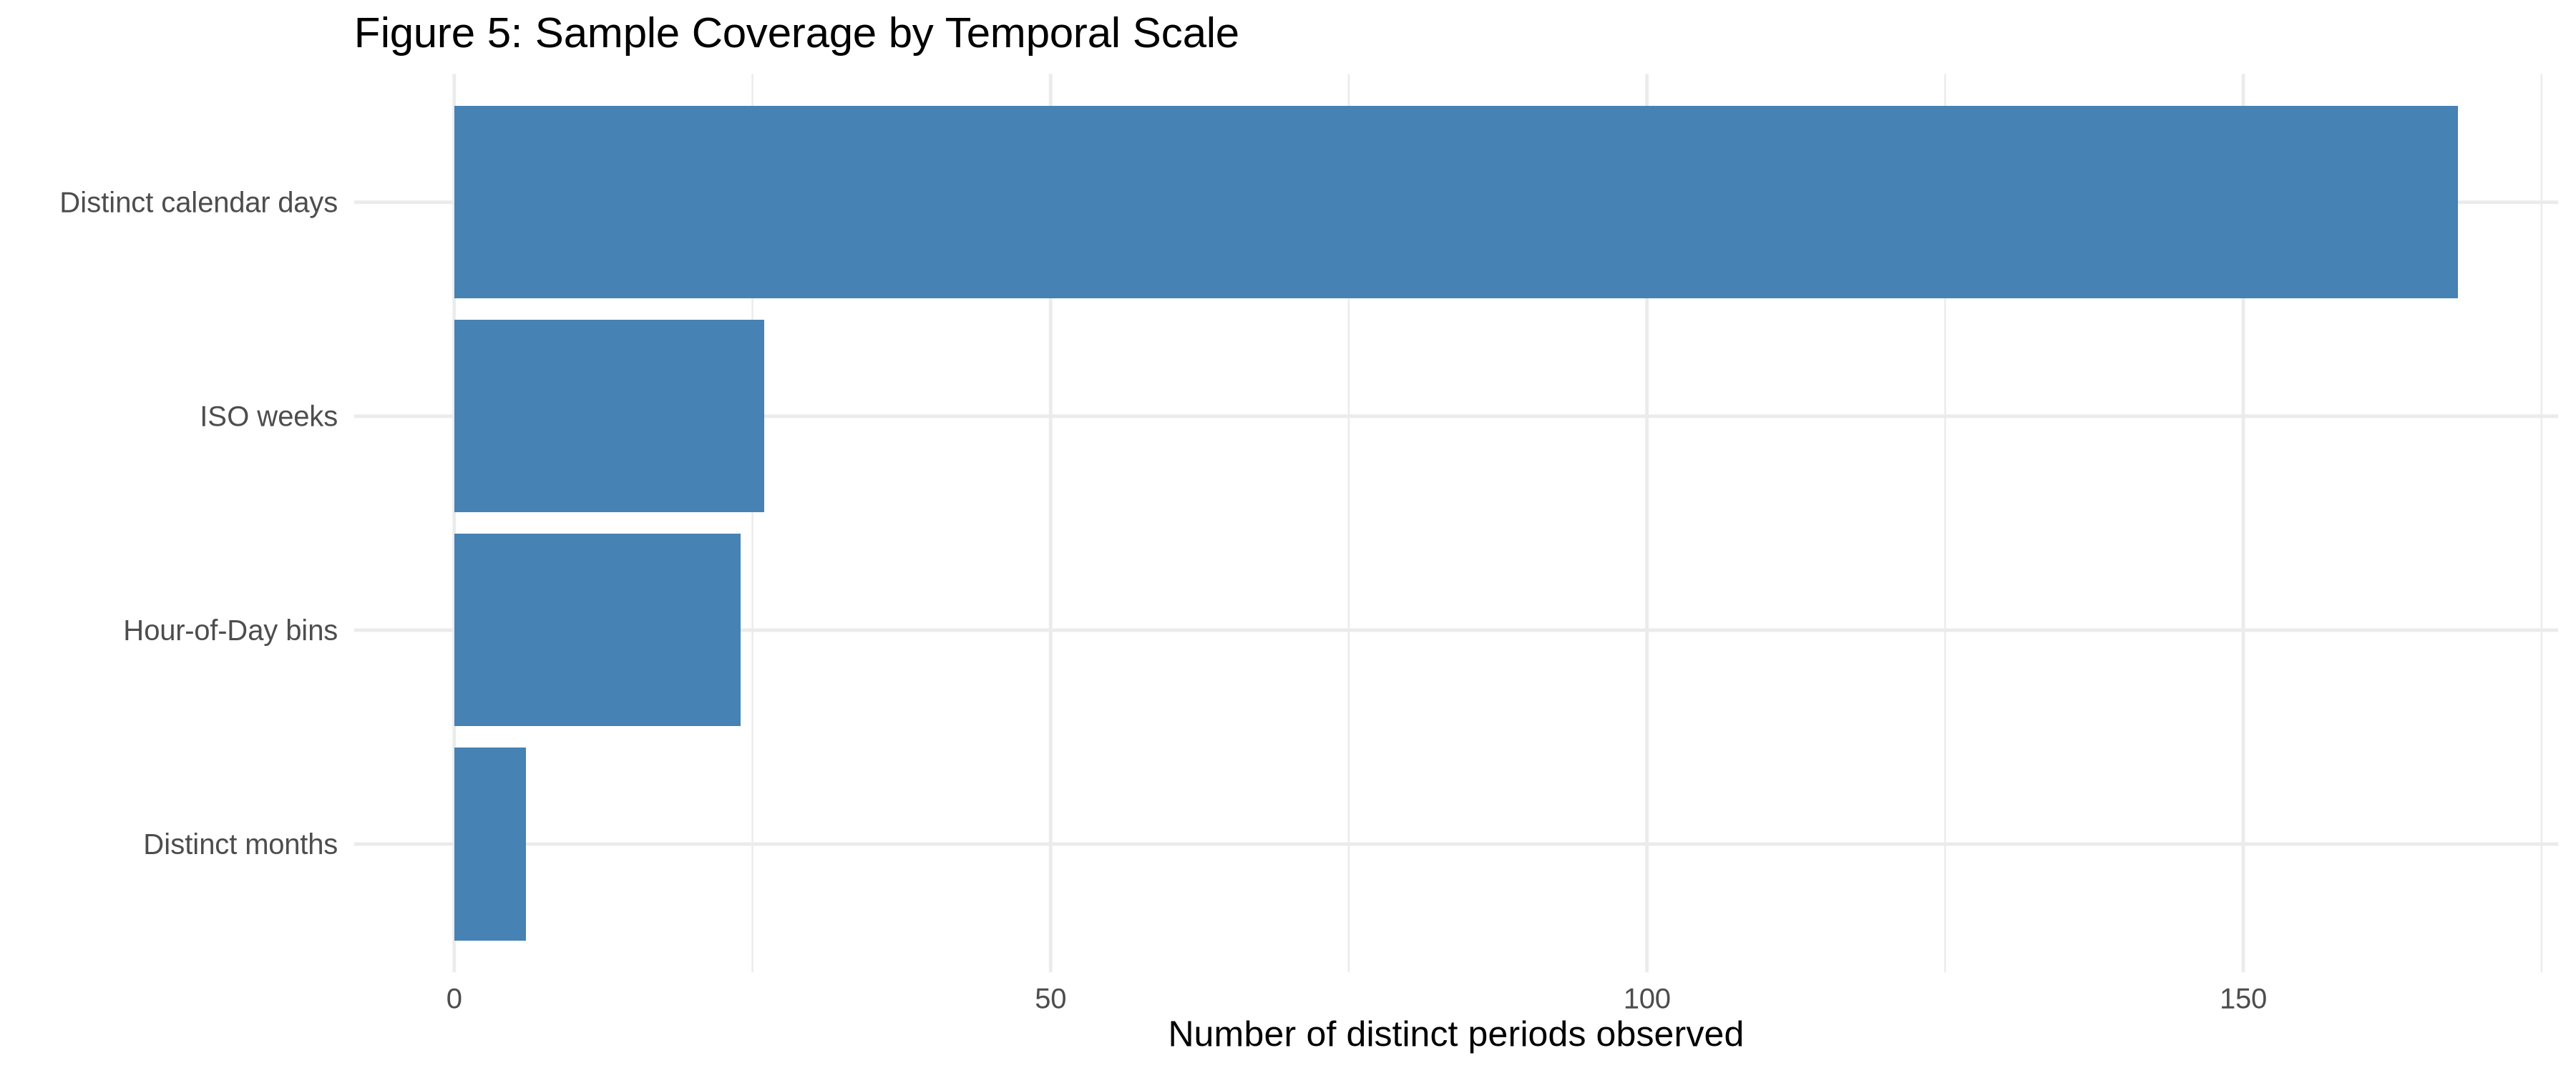

In [125]:
# create four derived keys, then count unique values
coverage_df <- hourly |>
  transmute(
    hour_key  = hour(hour_seq),                       # 0–23  (24 possible)
    day_key   = as_date(hour_seq),                    # calendar date
    week_key  = paste0(year(hour_seq), "-W", isoweek(hour_seq)),
    month_key = floor_date(hour_seq, unit = "month")
  ) |>
  summarise(
    hours  = n_distinct(hour_key),   # will always be 24
    days   = n_distinct(day_key),
    weeks  = n_distinct(week_key),
    months = n_distinct(month_key)
  ) |>
  pivot_longer(everything(),
               names_to  = "scale",
               values_to = "n_periods") |>
  mutate(scale = recode(scale,
                        hours  = "Hour-of-Day bins",
                        days   = "Distinct calendar days",
                        weeks  = "ISO weeks",
                        months = "Distinct months"))

ggplot(coverage_df, aes(reorder(scale, n_periods), n_periods)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = "Figure 5: Sample Coverage by Temporal Scale",
       x = "", y = "Number of distinct periods observed")

## 4 Model
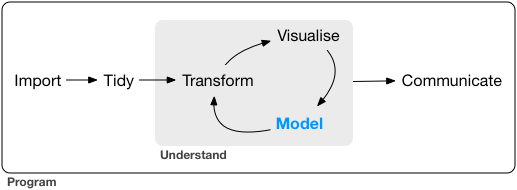

**Now we can proceed with creating a model that can answer our predictive question**

## 4.1 Feature engineering

In [151]:
lagged_cat <- hourly |>
  arrange(hour_seq) |> # arrgenges for the split
  mutate(
    lag1  = lag(concurrent_players,  1),
    lag24 = lag(concurrent_players, 24),
    hour  = factor(hour(hour_seq), levels = 0:23),   # 24-level factor(hours)
    dom   = factor(day(hour_seq))                    # up to 31 levels(days)
  ) |>
  drop_na()                                          # remove first 24 rows

### 4.2 Chronological split (reuse 80/20)
* We can use our ordered data to split

In [161]:
split_cat <- initial_time_split(lagged_cat, prop = 0.80)
train_cat <- training(split_cat)
test_cat  <- testing(split_cat)

### 4.3 Recipe: one-hot encode hour & dom, standardise numeric lags

In [154]:
rec_cat <- recipe(concurrent_players ~ lag1 + lag24 + hour + dom,
                  data = train_cat) |>
  step_center(all_numeric_predictors()) |>
  step_scale(all_numeric_predictors()) |>
  step_dummy(all_nominal_predictors())

### 4.4 Model spec & workflow

In [155]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

wf_cat <- workflow() |>
  add_recipe(rec_cat) |>
  add_model(lm_spec)

### 4.5  5-fold CV on training set

In [156]:
set.seed(2020)
folds_cat <- vfold_cv(train_cat, v = 5)

cv_cat <- fit_resamples(
  wf_cat,
  resamples = folds_cat,
  metrics   = metric_set(rmse, mae)
)

collect_metrics(cv_cat) |>
  knitr::kable(caption = "Table – CV metrics with hour + dom predictors")


→ A | warning: prediction from rank-deficient fit; consider predict(., rankdeficient="NA")

There were issues with some computations   A: x1

There were issues with some computations   A: x5







Table: Table – CV metrics with hour + dom predictors

|.metric |.estimator |      mean|  n|   std_err|.config              |
|:-------|:----------|---------:|--:|---------:|:--------------------|
|mae     |standard   | 0.8650499|  5| 0.0107817|Preprocessor1_Model1 |
|rmse    |standard   | 1.1907066|  5| 0.0645652|Preprocessor1_Model1 |

### 4.6  Final fit and hold-out(testing set) evaluation 
**Make a df that makes it easy to compare the linear regression prediction to the hold out data**

In [157]:
fit_cat <- fit(wf_cat, data = train_cat)

pred_cat <- predict(fit_cat, new_data = test_cat) |>
  bind_cols(test_cat)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
“prediction from rank-deficient fit; consider predict(., rankdeficient="NA")”


## 5 Visualizing the results

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
“prediction from rank-deficient fit; consider predict(., rankdeficient="NA")”


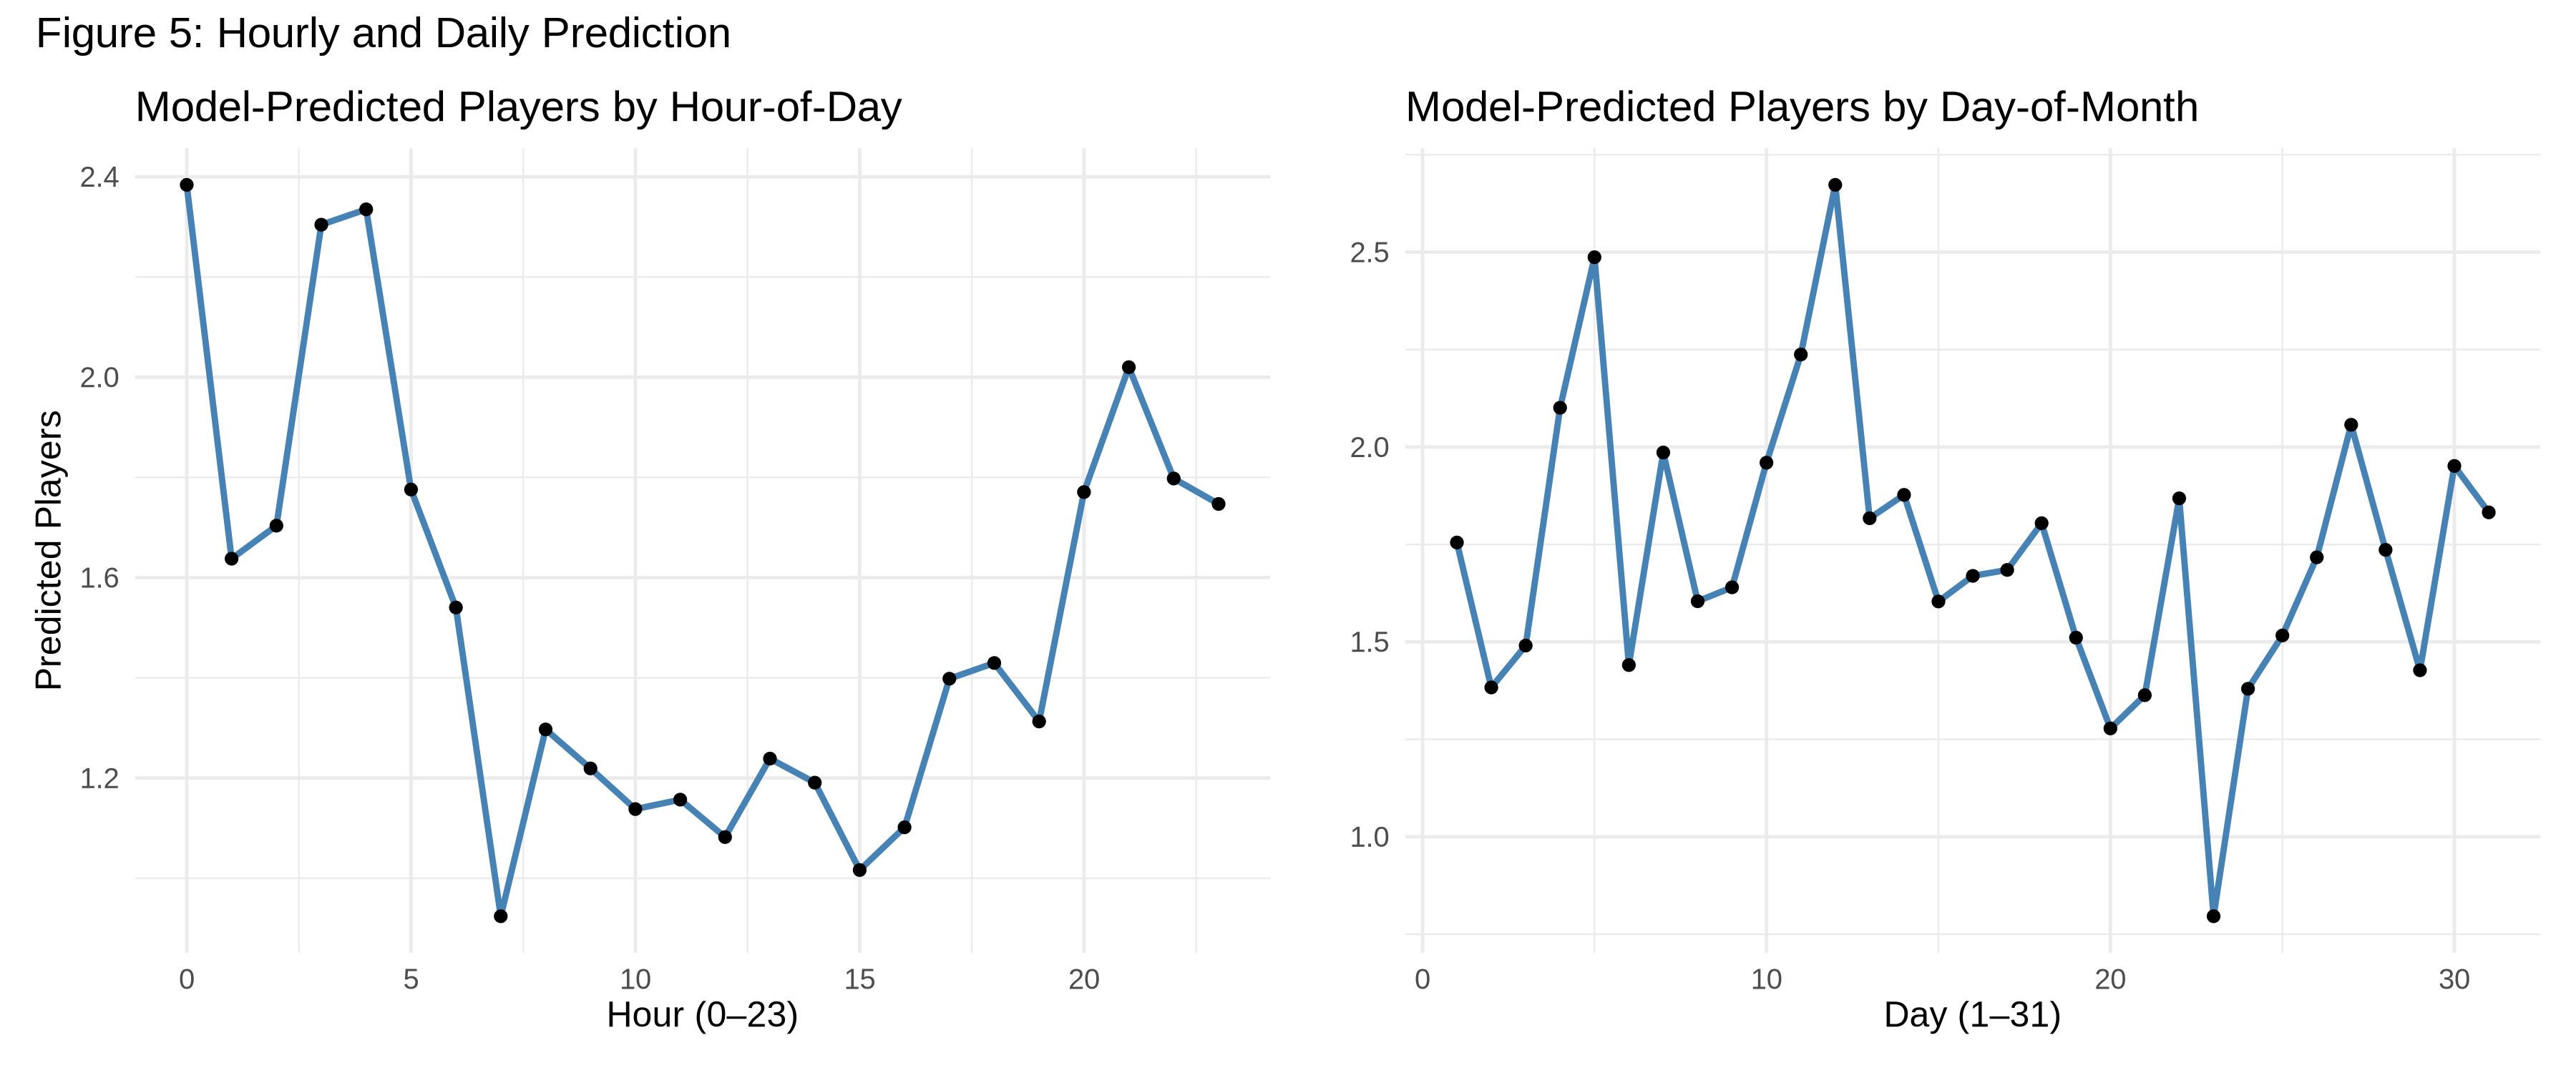

In [158]:
# Add model predictions back to data 
pred_df <- predict(fit_cat, new_data = lagged_cat) |>
  bind_cols(lagged_cat)            # keep hour & dom factors

# Hour-of-day effect
p_hour <- pred_df |>
  group_by(hour) |>
  summarise(pred_mean = mean(.pred), .groups = "drop") |>
  ggplot(aes(as.integer(as.character(hour)), pred_mean)) +
  geom_line(colour = "steelblue", linewidth = 1) +
  geom_point() +
  labs(title = "Model-Predicted Players by Hour-of-Day",
       x = "Hour (0–23)", y = "Predicted Players")

# Day-of-month effect 
p_dom <- pred_df |>
  group_by(dom) |>
  summarise(pred_mean = mean(.pred), .groups = "drop") |>
  ggplot(aes(as.integer(as.character(dom)), pred_mean)) +
  geom_line(colour = "steelblue", linewidth = 1) +
  geom_point() +
  labs(title = "Model-Predicted Players by Day-of-Month",
       x = "Day (1–31)", y = "")

# Display side-by-side 
(p_hour | p_dom) + 
  plot_annotation(title = "Figure 5: Hourly and Daily Prediction")

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
“prediction from rank-deficient fit; consider predict(., rankdeficient="NA")”


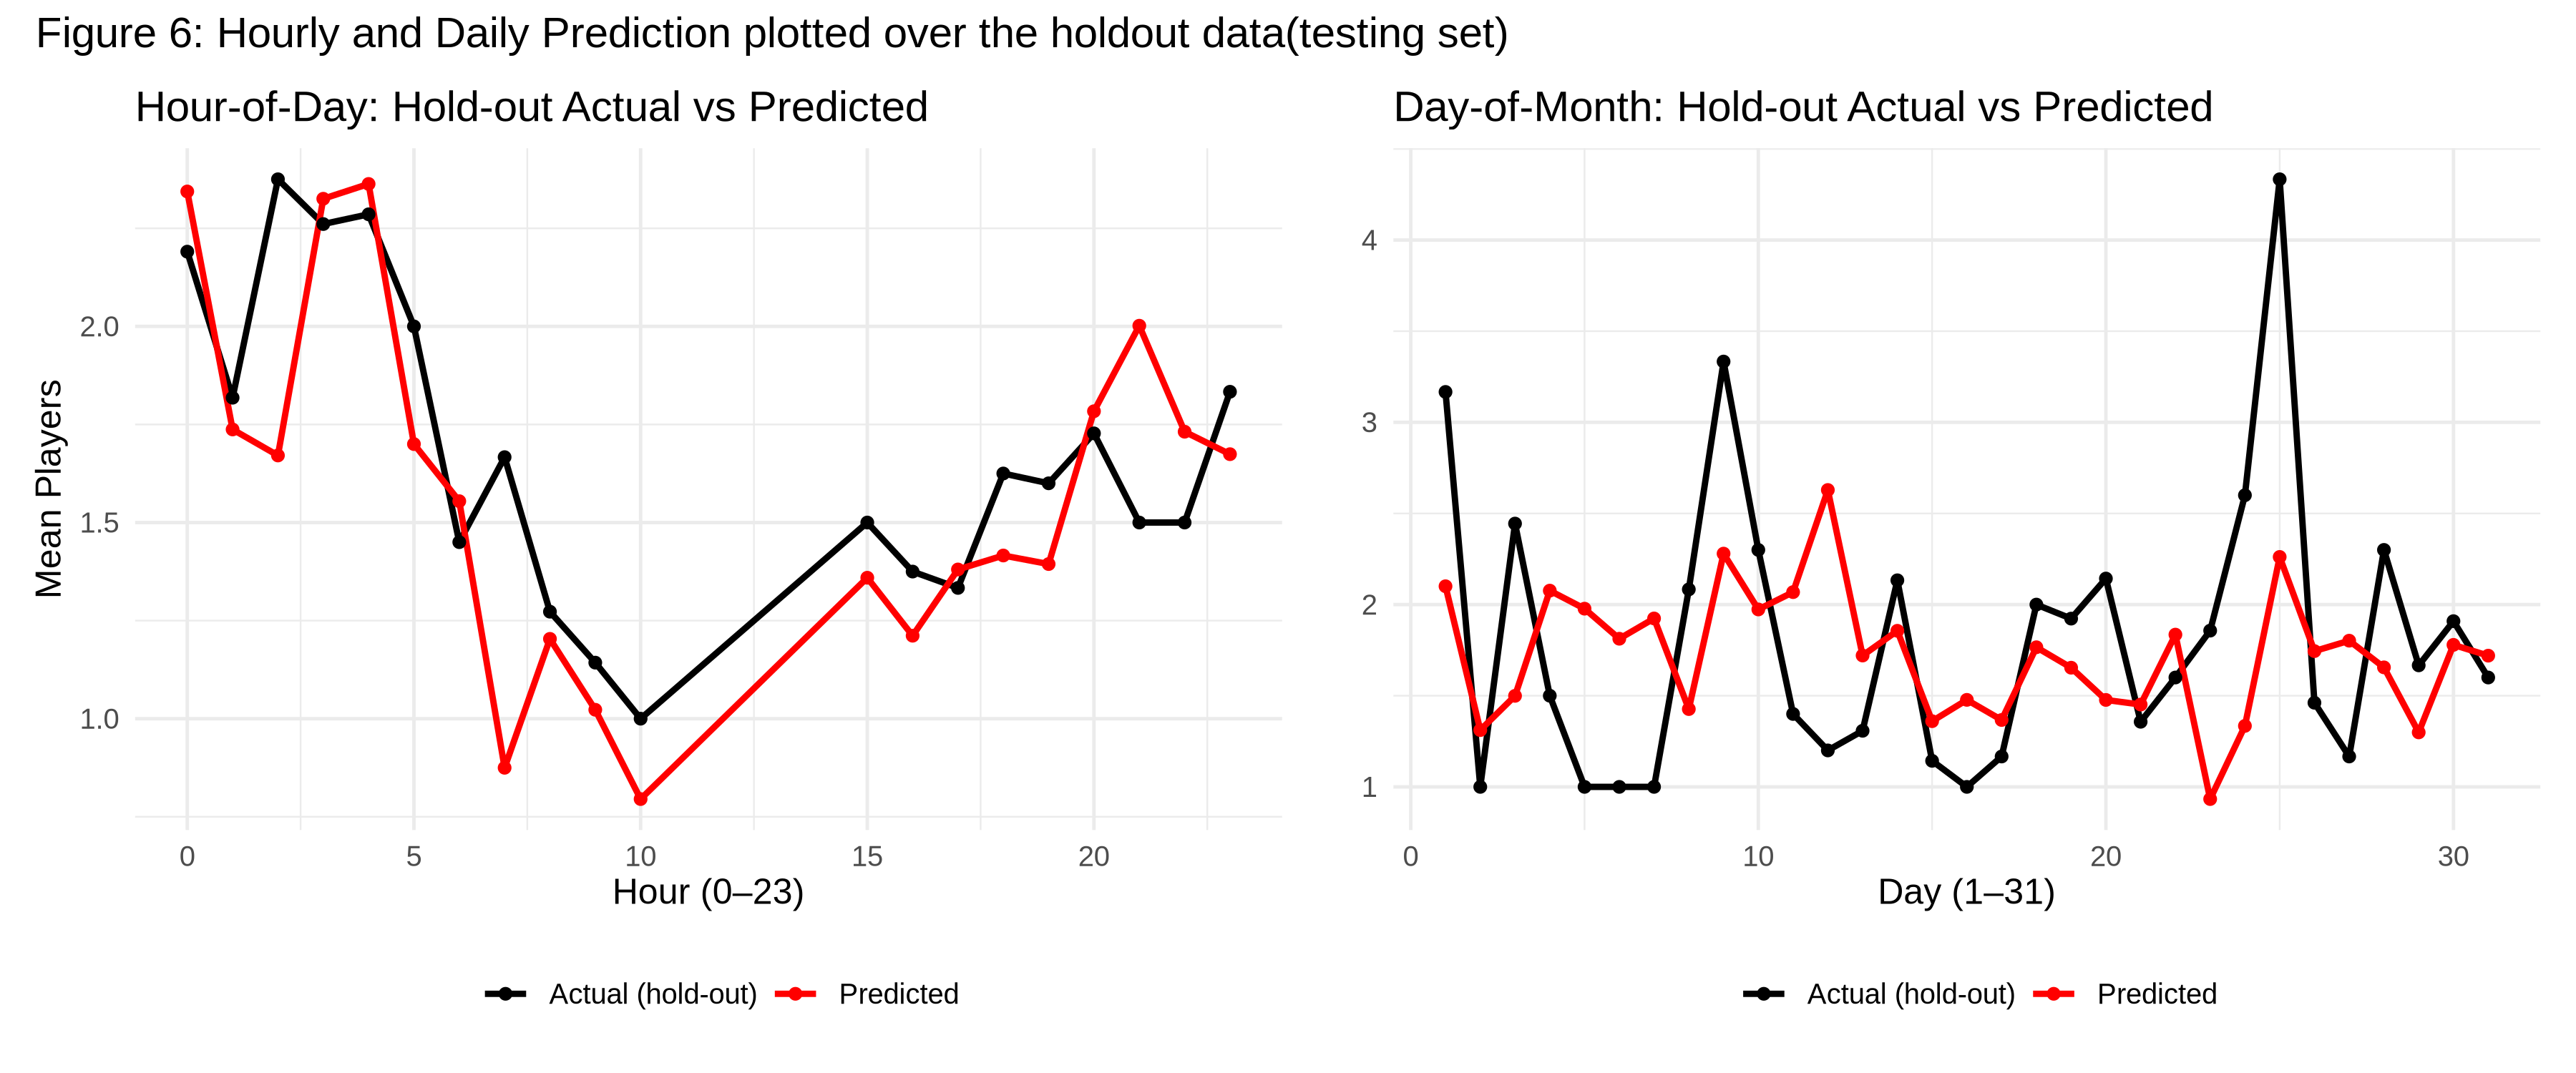

In [164]:
# Get predictions for the hold-out set
test_pred <- predict(fit_cat, new_data = test_cat) |> bind_cols(test_cat)

# Hour-of-day comparison on hold-out
hour_hold  <- test_pred |>
  group_by(hour) |>
  summarise(actual    = mean(concurrent_players),
            predicted = mean(.pred),
            .groups   = "drop") |>
  pivot_longer(c(actual, predicted),
               names_to  = "series",
               values_to = "mean_players")

p_hour <- ggplot(hour_hold,
                 aes(as.integer(as.character(hour)),
                     mean_players,
                     colour = series,
                     group  = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(values = c(actual = "black", predicted = "red"),
                      labels  = c("Actual (hold-out)", "Predicted")) +
  labs(title  = "Hour-of-Day: Hold-out Actual vs Predicted",
       x      = "Hour (0–23)", y = "Mean Players", colour = "") +
  theme(legend.position = "bottom")

# Day-of-month comparison on hold-out
dom_hold <- test_pred |>
  group_by(dom) |>
  summarise(actual    = mean(concurrent_players),
            predicted = mean(.pred),
            .groups   = "drop") |>
  pivot_longer(c(actual, predicted),
               names_to  = "series",
               values_to = "mean_players")

p_dom <- ggplot(dom_hold,
                aes(as.integer(as.character(dom)),
                    mean_players,
                    colour = series,
                    group  = series)) +
  geom_line(linewidth = 1) +
  geom_point() +
  scale_colour_manual(values = c(actual = "black", predicted = "red"),
                      labels  = c("Actual (hold-out)", "Predicted")) +
  labs(title  = "Day-of-Month: Hold-out Actual vs Predicted",
       x      = "Day (1–31)", y = "", colour = "") +
  theme(legend.position = "bottom")

# Side-by-side
(p_hour | p_dom) + 
  plot_annotation(title = "Figure 6: Hourly and Daily Prediction plotted over the holdout data(testing set)")

In [160]:
lag_summary <- lagged_cat |>
  summarise(across(
    .cols  = c(lag1, lag24),
    .fns   = list(mean = mean, sd = sd, min = min, max = max),
    .names = "{.col}_{.fn}"
  )) |>
  pivot_longer(everything(),
               names_to  =a c("Lag", ".value"),
               names_sep = "_")

lag_summary

ERROR: Error in parse(text = x, srcfile = src): <text>:8:29: unexpected symbol
7:   pivot_longer(everything(),
8:                names_to  =a c
                               ^


## 6 Discussion

summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

## 7 References